<a href="https://colab.research.google.com/github/catafest/colab_google/blob/master/catafest_027.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

... testing the new Torch-TensorRT ...

This is a ***PyTorch*** integration for TensorRT inference optimizations on ***NVIDIA GPUs***. With just one line of code, it speeds up performance **up to 6x.**

based on this video tutorial: [Inference with Torch-TensorRT Deep Learning Prediction for Beginners - CPU vs CUDA vs TensorRT](https://https://www.youtube.com/watch?v=iFADsRDJhDM) by **Python Simplified youtube channel.**

In [169]:
!pip3 install torch-tensorrt -f https://github.com/NVIDIA/Torch-TensorRT/releases

Looking in links: https://github.com/NVIDIA/Torch-TensorRT/releases


In [170]:
!apt install python3-libnvinfer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-libnvinfer is already the newest version (8.2.3-1+cuda11.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [171]:
!pip install --upgrade torch-tensorrt

In [172]:
!git clone https://github.com/NVIDIA/Torch-TensorRT

fatal: destination path 'Torch-TensorRT' already exists and is not an empty directory.


In [173]:
!cd Torch-TensorRT

In [174]:
import torch
from torchvision import models, transforms

# using gpu cuda colab

In [175]:
model = models.resnet50(pretrained=True).to("cuda")

In [176]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
  

In [177]:
!rm *.jpg

In [178]:
files = upload_files()
print(files)

Saving catafest.jpg to catafest.jpg
['catafest.jpg']


In [179]:
!ls

catafest.jpg  sample_data  Torch-TensorRT


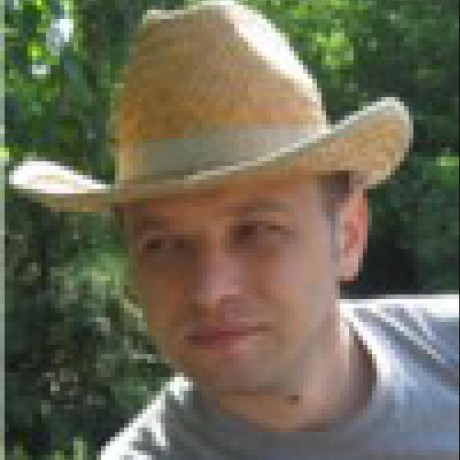

In [180]:
from PIL import Image
# this load first image from all files updated with upload_files()
img = Image.open(files[0])
img

step 3: transform example image (pre-processing)

In [181]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


In [182]:
#using gpu
img_batch = torch.unsqueeze(img, 0).to("cuda")
img_batch.shape

torch.Size([1, 3, 224, 224])

step 5: make a prediction and get probabilities for each class

In [183]:
model.eval()
with torch.no_grad():
    outputs = model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

step 6: get the names of all available ImageNet classes
source: https://github.com/pytorch/hub/blob/master/imagenet_classes.txt

In [184]:
!pip install pandas

In [185]:
import pandas as pd

categories = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)
categories[0][2]

'great white shark'

In [186]:
topk = 5

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%58 tench
%13 cowboy hat
%7 barracouta
%7 sombrero
%2 gar


In [187]:
#copy from TRT
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(32, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

step 10: find out CUDA model speed benchmarks

In [188]:
#CUDA benchmarks
model = model.to("cuda")
benchmark(model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 83.06 ms
Iteration 20/100, ave batch time 83.67 ms
Iteration 30/100, ave batch time 83.59 ms
Iteration 40/100, ave batch time 83.68 ms
Iteration 50/100, ave batch time 84.00 ms
Iteration 60/100, ave batch time 84.03 ms
Iteration 70/100, ave batch time 84.09 ms
Iteration 80/100, ave batch time 84.12 ms
Iteration 90/100, ave batch time 84.19 ms
Iteration 100/100, ave batch time 84.20 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 84.20 ms


In [189]:
traced_model = torch.jit.trace(model, [torch.randn((32, 3, 224, 224)).to("cuda")])

In [190]:
import torch_tensorrt

trt_model = torch_tensorrt.compile(
    traced_model,
    inputs = [torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = {torch.float32}
)

In [191]:
benchmark(trt_model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 63.80 ms
Iteration 20/100, ave batch time 64.02 ms
Iteration 30/100, ave batch time 63.97 ms
Iteration 40/100, ave batch time 64.02 ms
Iteration 50/100, ave batch time 64.14 ms
Iteration 60/100, ave batch time 64.14 ms
Iteration 70/100, ave batch time 64.18 ms
Iteration 80/100, ave batch time 64.24 ms
Iteration 90/100, ave batch time 64.26 ms
Iteration 100/100, ave batch time 64.29 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 64.29 ms


In [192]:
trt_model.eval()
with torch.no_grad():
    outputs = trt_model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%58 tench
%13 cowboy hat
%7 barracouta
%7 sombrero
%2 gar


I used my logo avatart 

https://ro.gravatar.com/userimage/7245526/573a0d3838b10edf526aef9eced186e1.jpg?size=200

and these are the results ... :

*%58 tench*

*%13 cowboy hat*

*%7 barracouta*

*%7 sombrero*

*%2 gar*

